In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

### Negaive Binom

In [17]:
k, μ = 10, 100
xs = np.random.negative_binomial(k, p=k/(k+μ), size=100000)

In [16]:
zs = np.random.gamma(shape=k, scale=1/k, size=100000)
xs = np.random.poisson(μ*zs)

<AxesSubplot: ylabel='Count'>

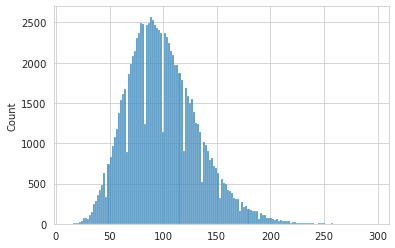

In [15]:
sns.histplot(xs)

<AxesSubplot: ylabel='Count'>

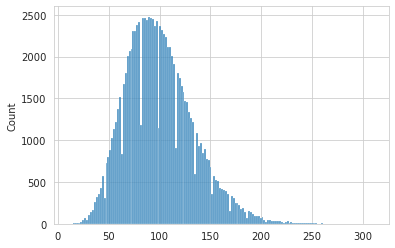

In [19]:
sns.histplot(xs)

In [85]:
def test_stat(x):
    mean = x.mean()
    return ((x - mean)**2).sum() / mean

n = 36
r = 1164
k = 100

ts = []
for i in range(500000):
    u = np.random.dirichlet(np.ones(n)*k)
    x = np.random.multinomial(n=r, pvals=u)
    t = test_stat(x)
    ts.append(t)

ts = np.array(ts)

In [98]:
sample_mean = 1164 / n
t_obs = 1/sample_mean * (39508 - n*sample_mean**2)
t_obs

57.89690721649462

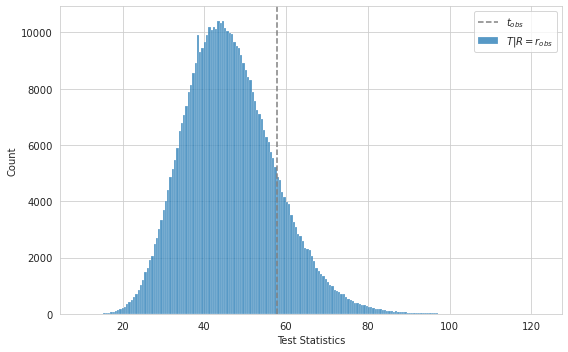

In [106]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(ts, ax=ax, bins=200, label='$T|R=r_{obs}$')
ax.axvline(t_obs, color='grey', linestyle='--', label='$t_{obs}$')
ax.set_xlabel('Test Statistics')
ax.legend()
fig.tight_layout()

In [107]:
(ts >= t_obs).mean()

0.148136